<a href="https://colab.research.google.com/github/sdhar2020/Ease-of-Doing-Business-Model/blob/master/Case_Study_Ease_of_Doing_Business_with_a_GC_score_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & Settings
In this work various libraries such as Sci-Kit Learn, matplotlib, Google Drive related, XGBoost Libraries are used

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import random  as rnd
import copy
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import copy
import seaborn as sns
from scipy import stats
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, log_loss
import xgboost as xgb
from xgboost import plot_tree
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Problem Statement

Payments in the construction inustry are governed by different set of laws owing to the nature of business as thee is little or no way of repossessing spent materials or time after completion of work.

The laws and regulations are different by state and even counties in the US. Usually a large construction project is awarded to a General Constructor (GC) who then might seek to contractually employ multiple contractors, Sub-Contractors and suppliers.

However, in general the property owner is liable if a sub or a sub-sub etc doesn't get paid making payment realization a key challenge.

In order to provide greater transperancy for the sub-contractors a product feature such as a rating for the GC's is envisioned. 

Without access to actual payments information or firmographics, the implicit assumption is that historically legal documents submitted with a GC is a good indicator of ease of doing business with the GC.

The intuition here is that ratings provided by Subs to GCs can be predicted using the document history to create a 5 point rating

# Legal Document Data 
Depending on the local regulations a sub-contractor has to provide specific documents at the inception of a construction related activity e.g. a Notice of Intent, depending on the status of payment e.g. raising a Lien.

The various documents that are sumitted to a GC can abstracted to a document type to adjust for regional differences. There are 4 document types that are used:

1. Visibility: Project progress report and such
2. Payment: Payments related document 
3. Escalation: Escalations related to payment requests
4. Last Resort: Last Resort type documents e.g. actual Lien Notice

The data used is completely anonymized of any PCI/PII and firmographics information and the primary identifier is a Hex UUID. Specific contruction projects are represented by the US Zip code as a unique identifier

Users are sub-contractors, sub-subs or suppliers who may have raised one or more of the 4 document types related to a specific General Contractor Project.







In [ ]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/Ease of Business Score

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Ease of Business Score


In [ ]:
df = pd.read_csv('zipleveldata01132020.csv', low_memory=False)

In [ ]:
df.shape

(212707, 25)

In [ ]:
df= df.dropna(subset=['gc_uuid', 'proj_surrogate_zip'])

In [ ]:
df.shape

(149223, 25)

In [ ]:
gc_uuid_lst= df['gc_uuid'].unique()
len(df['gc_uuid'].unique())

48396

The data is for 48396 GC's who have had any document related activity in the past 365 days. Some of the GC's have upwards of 1000 activities and a large proportions have had only 1 in the past 365 days

# Exploring Document Type Data

The data is arranged at a Project Level as counts of visibility, payment, escalation and lastresort related document type activity in the past 90, 180, 365 days.

This means 365 days contain all the data for 90 and 180 days.



In [ ]:
# Periods of the data
periods = [90,180,365]

In [ ]:
# Words as in document types
words= ['visibility','payment','escalation','lastresort']

We create a set of count and summary metrics at each GC level.
- Count of each word for deltas of  90 days, 90-180 days, 180-365 days
- Count of each term/ word in each deta
- Total number of words for each GCs in each delta
- user count with terms
- Project count with terms



In [ ]:
def aggregate_order(df, periods, words):
  df= df.copy(deep= True)
  for w in words:
    df['d_'+w+'_'+str(periods[2])]= df[w+'_'+str(periods[2])]- df[w+'_'+str(periods[1])]
    df['d_'+w+'_'+str(periods[1])]= df[w+'_'+str(periods[1])]- df[w+'_'+str(periods[0])]
    df['d_'+w+'_'+str(periods[0])]= df[w+'_'+str(periods[0])]
  dfs = []
  for p in periods:
    terms = ['d_'+w+'_'+str(p) for w in words]
    df['d_row_terms_'+str(p)]= df[terms].sum(axis=1)
    all_terms = terms+ ['d_row_terms_'+str(p)]
    metrics= df.groupby('gc_uuid').sum()[all_terms] # terms in the doc
    nm_chng= dict(zip(metrics.columns.tolist(), all_terms))
    metrics= metrics.rename(columns=nm_chng)
    proj_gc = df[df['d_row_terms_'+str(p)]!=0].groupby(["gc_uuid"])["proj_surrogate_zip"].nunique() # Total project in  GC
    proj_gc.name = 'proj_cnt_'+str(p)
    metrics = metrics.merge(proj_gc, on = 'gc_uuid', how='left')
    user_gc = df[df['d_row_terms_'+str(p)]!=0].groupby(["gc_uuid"])["user_id"].nunique() # Total project in  GC
    user_gc.name = 'usr_cnt_'+str(p)
    metrics= metrics.merge(user_gc, on = 'gc_uuid', how='left')
    dfs.append(metrics)
  return(dfs)

In [ ]:
lst =aggregate_order(df,periods, words)

In [ ]:
lst= [l.fillna(0) for l in lst]

In [ ]:
df2= pd.concat(lst, axis=1)

# Heuristic Ranking

In [ ]:
hf= lst[2]

In [ ]:
hf= hf[['d_'+w+'_365' for w in words]].div(hf['proj_cnt_365'].replace(0,1), axis=0)

In [ ]:
hf['rank']= hf.d_lastresort_365.rank(axis=0, ascending= False, method='dense')*1000+\
hf.d_escalation_365.rank(axis=0, ascending= False, method='dense')*100+\
hf.d_visibility_365.rank(axis=0, ascending= True, method='dense')*10+\
hf.d_payment_365.rank(axis=0, ascending= True, method='dense')*1

In [ ]:
hf['fin_rnk']= hf['rank'].rank(axis=0, ascending= True, method='dense')

In [ ]:
hf['bkt']= pd.cut(hf['fin_rnk'],bins=5,labels= False, include_lowest=True)+1

In [ ]:
hf['bkt'].value_counts()

4    37009
3     5011
5     3382
1     1605
2     1389
Name: bkt, dtype: int64

## Data Values


Observations from the diagram below:
- The data in itself is concentrated to count of 0 or 1. 
- Also based on the white shades it appears that very few GC's actually have contiguous document related data across the past 365 days.
- This is likely to create challenges of large number of 0's or NaN values when creating features

<Figure size 1080x1080 with 0 Axes>

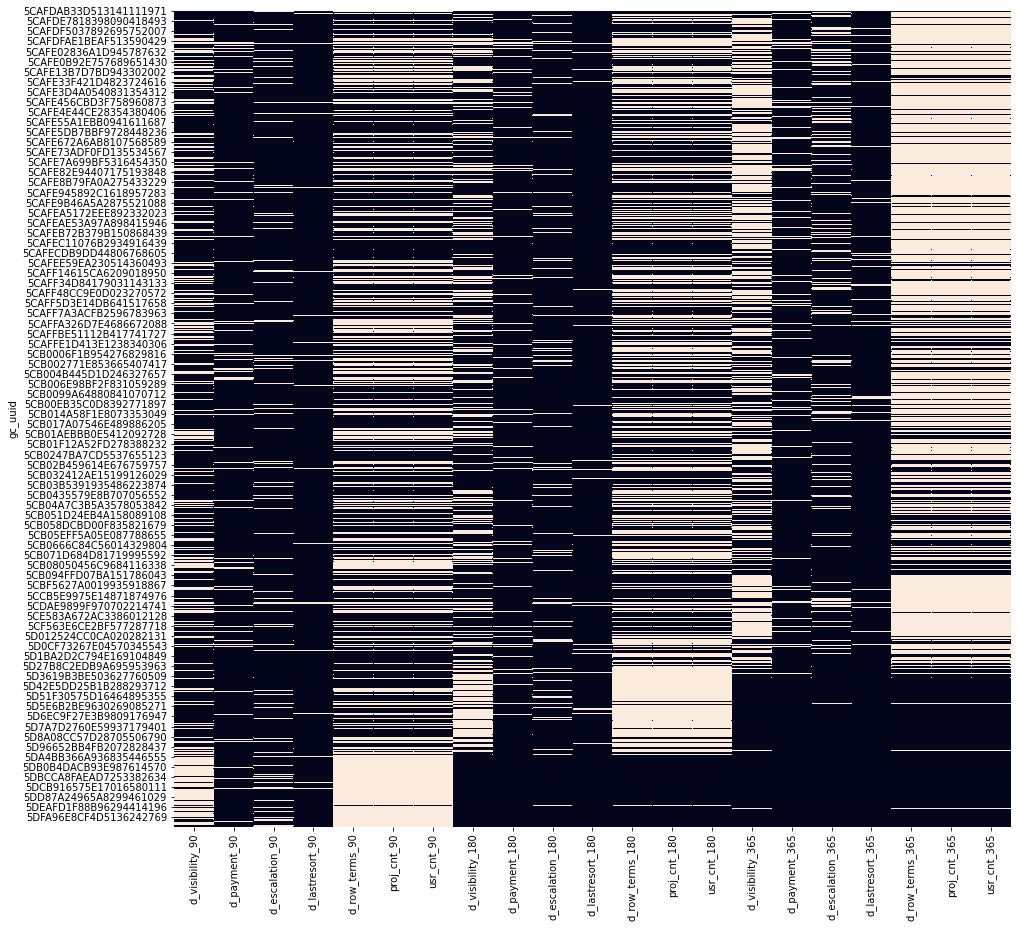

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df2 > 0, cbar=False)

## Feature Selection
- Owing to the disproportionate distribution of the different document types and prepnderance of document types in one set of GCs and missing in another, decided to use TfIdf, features to weigh down or up the distribution of different document type
- Additionally we also create per usr and per project for each document type
- All features are L2 normalized to keep them range bound for each GC

In [ ]:
def final_features(df, periods, words, normalization = 'L2'):
  df = df.copy(deep= True)
  total_docs = len(df.index.unique())
  for p in periods:
    terms = ['d_'+w+'_'+str(p) for w in words]
    for i, t in enumerate(terms):
      df['tf_'+t]= df[t]/(df['d_row_terms_'+str(p)].replace(0,1))
      df['doc_w_'+t] = df2[df2[t]!=0].index.nunique() 
      df['wpp_'+t]= df[t]/(df['proj_cnt_'+str(p)].replace(0,1))
      df['wpu_'+t]= df[t]/(df['usr_cnt_'+str(p)].replace(0,1))
      df['idf_'+t] = np.log(total_docs/df['doc_w_'+t].replace(0,1))
      df['tfidf_'+t]= df['tf_'+t]*df['idf_'+t]
    l2t= np.sqrt(np.square(df[['tfidf_'+t for t in terms]].sum(axis=1)))
    l2p= np.sqrt(np.square(df[['wpp_'+t for t in terms]].sum(axis=1)))
    l2u= np.sqrt(np.square(df[['wpu_'+t for t in terms]].sum(axis=1)))
    for t in terms:
      df['ntfidf_'+t]= df['tfidf_'+t]/l2t
      df['nwpp_'+t]= df['wpp_'+t]/l2p
      df['nwpu_'+t]= df['wpu_'+t]/l2u
  return(df)

In [ ]:
features= final_features(df2, periods, words, 'L2')

In [ ]:
# prefix of all variables
column_terms = ['doc_w','tf_','idf_','tfidf_','ntfidf_','nwpp_','nwpu_', 'wpp_', 'wpu_']

In [ ]:
# Feature slices
slice_dict={}
for c in column_terms:
  dummy = []
  for f in features.columns.to_list():
    if f.startswith(c):
      dummy.append(f)
  slice_dict[c]= dummy

In [ ]:
ffeats= slice_dict['ntfidf_']+ slice_dict['nwpp_']+ slice_dict['nwpu_']
# ffeats.append('usr_proj_ratio')

In [ ]:
 features= features[ffeats]

In [ ]:
features.shape

(48396, 36)

# GC Ratings
Ratings have been randomly collected for GC's from sub contractors and users. The objective is to fit a algorithm to predict the ratings fo non-rated group

The ratings are assigned as 1-10. However, from the perspective of the classification problem they are all converted into 1-5 star ratings. All the assigned ratings are given equal weights.




In [ ]:
rt  = pd.read_csv('ratings01142020.csv', low_memory=False)

In [ ]:
rt.shape

(6740, 2)

In [ ]:
gc_rating= rt.groupby('uuid').rating.agg(['mean','count','sum'])

In [ ]:
gc_rating.shape

(4811, 3)

It seems 4811 unique GC's have been given 1-10 ratings at different frquencies

In [ ]:
gc_rating['mean'].value_counts(bins=5)

(8.2, 10.0]    2361
(6.4, 8.2]      786
(0.99, 2.8]     696
(4.6, 6.4]      667
(2.8, 4.6]      301
Name: mean, dtype: int64

In [ ]:
alldata = features.merge(gc_rating, left_index=True, right_index=True, how='left')

In [ ]:
alldata.shape

(48396, 39)

In [ ]:
ad = alldata.dropna()

In [ ]:
ad.shape

(892, 39)

In [ ]:
ad['mean'].value_counts(bins=5, dropna= False)

(8.2, 10.0]    414
(6.4, 8.2]     156
(0.99, 2.8]    127
(4.6, 6.4]     123
(2.8, 4.6]      72
Name: mean, dtype: int64

The buckets are given as follows:
- 0-3: 1 Star
- 3-5: 2 Star
- 5-7: 3 Star
- 7-9: 4 Star
- 9-10: 5 Star




In [ ]:
bins = [0, 3, 5, 7, 9, 10.0]
labels =['1 Star','2 Star','3 Star','4 Star', '5 Star']
ad['y']= pd.cut(ad['mean'], bins, labels = labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
ad['y'].value_counts()

5 Star    314
4 Star    189
1 Star    156
3 Star    138
2 Star     95
Name: y, dtype: int64

Total 892 GC's found with different ratings

# Train & Test data split/ Prepropcessing

In [ ]:
def prep_data_model(df, collist =ffeats):
  df = df.copy(deep=True)
  test = df[df['y'].isnull()]
  train= df[df['y'].notnull()]
  labels=  train.loc[:, train.columns == 'y']
  train = train[collist]
  test = test[collist]
  return(train,test,labels)


In [ ]:
train,test,labels= prep_data_model(ad, ffeats)

# ML Algorithm: XGBoost

A out of the box python implementation is used in this classification problem. While a Random Forest model was tried it didn't yield the best result.

A negative log loss quality metric was used to cross validte the XGBoost Model. A boosting tree will work in adding weights to the stumps while it optimizes the quality metric which is good for data where the distribution of data is disproportional


In [ ]:
def modelfit(alg, dtrain, predictors, labels, performCV=True, printFeatureImportance=True, cv_folds=5):
  #Fit the algorithm on the data
  l=LabelEncoder() 
  l.fit(labels.values.ravel()) 
  labels = l.transform(labels.values.ravel())
  alg.fit(dtrain[predictors], labels)
        
  #Predict training set:
  dtrain_predictions = alg.predict(dtrain[predictors])
  dtrain_predprob = alg.predict_proba(dtrain[predictors])
    
  #Perform cross-validation:
  if performCV:
    cv_score = cross_val_score(alg, dtrain[predictors], labels, cv=cv_folds, scoring='neg_log_loss')
    
  #Print model report:
  print("\nModel Report")
  print("Recall Micro : %.4g" % recall_score(labels, dtrain_predictions, average= 'micro'))
  print("Recall Macro : %.4g" % recall_score(labels, dtrain_predictions, average= 'macro'))
  print("Recall Weighted : %.4g" % recall_score(labels, dtrain_predictions, average= 'weighted'))
  print("Precision Micro : %.4g" % precision_score(labels, dtrain_predictions, average= 'micro'))
  print("Precision Macro : %.4g" % precision_score(labels, dtrain_predictions, average= 'macro'))
  print("Precision Weighted : %.4g" % precision_score(labels, dtrain_predictions, average= 'weighted'))
  print("Neg Log Loss (Train): %f" % log_loss(labels, dtrain_predprob))
    
  if performCV:
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
  #Print Feature Importance:
  if printFeatureImportance:
    plt.figure(figsize= (25,7))
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
RSEED = 50

In [ ]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 eval_metric= 'logloss',
 nthread=4,
 scale_pos_weight=1,
 seed=RSEED)

# XGBoost Modeling Results

- The negative Log Loss is around 0.268. This is like a 75% to 25% split in a binary classification situation
- The confusion metric shows a preponderence of all classes to be classified as 5 STar. This may a sample effect or the lack of negative indicators on training data that is actually termed negative


Model Report
Recall Micro : 0.8957
Recall Macro : 0.8745
Recall Weighted : 0.8957
Precision Micro : 0.8957
Precision Macro : 0.938
Precision Weighted : 0.9099
Neg Log Loss (Train): 0.268596
CV Score : Mean - -2.47408 | Std - 0.1662962 | Min - -2.644921 | Max - -2.195504


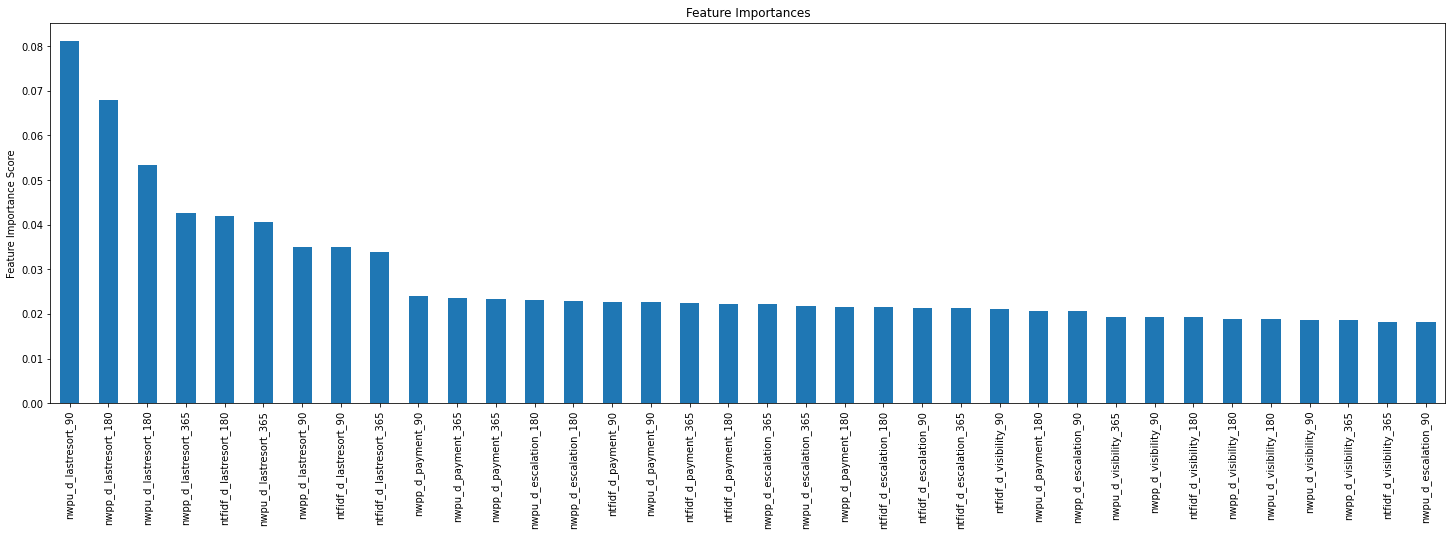

In [ ]:
modelfit(xgb1, train, ffeats, labels,True,True, 5)

In [ ]:
l=LabelEncoder()
l.fit(labels.values.ravel())
cm = confusion_matrix(l.transform(labels.values.ravel()), xgb1.predict(train),normalize= 'pred')

LabelEncoder()

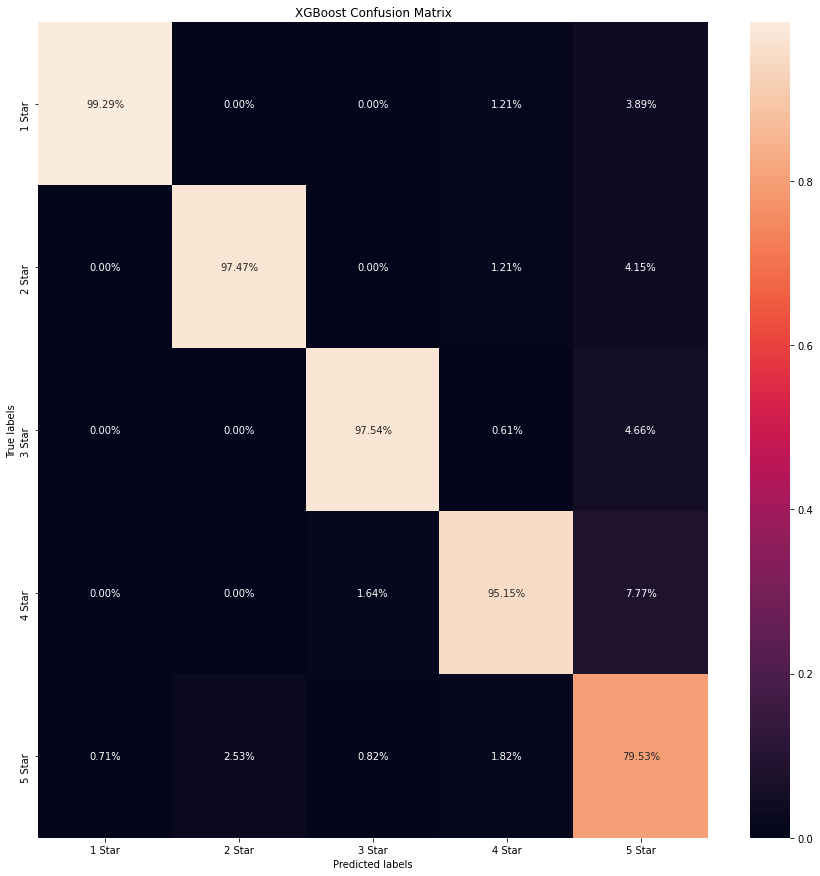

In [ ]:
labs =['1 Star','2 Star','3 Star','4 Star', '5 Star']
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt= '.2%', ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('XGBoost Confusion Matrix'); 
ax.xaxis.set_ticklabels(labs); ax.yaxis.set_ticklabels(labs);

In [ ]:
train['yhat']= xgb1.predict(train)+1

In [ ]:
train= train.merge(labels,how='left',left_index=True, right_index=True)

In [ ]:
recon = train.merge(hf['bkt'], how= 'left', left_index=True, right_index=True)

In [ ]:
recon['y']= recon['y'].apply(lambda x: int(x[0]))

In [ ]:
sum(recon['yhat']== recon['y'])/ 892

0.8957399103139013

In [ ]:
sum(recon['yhat']== recon['bkt'])/ 892

0.2522421524663677

In [ ]:
sum(recon['yhat']== recon['y'])/ 892 - sum(recon['yhat']== recon['bkt'])/ 892

0.6434977578475336

In [ ]:
cm2= confusion_matrix(recon.y.ravel(), recon.bkt.ravel(),normalize= 'pred')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:631: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  return self._values.ravel(order=order)


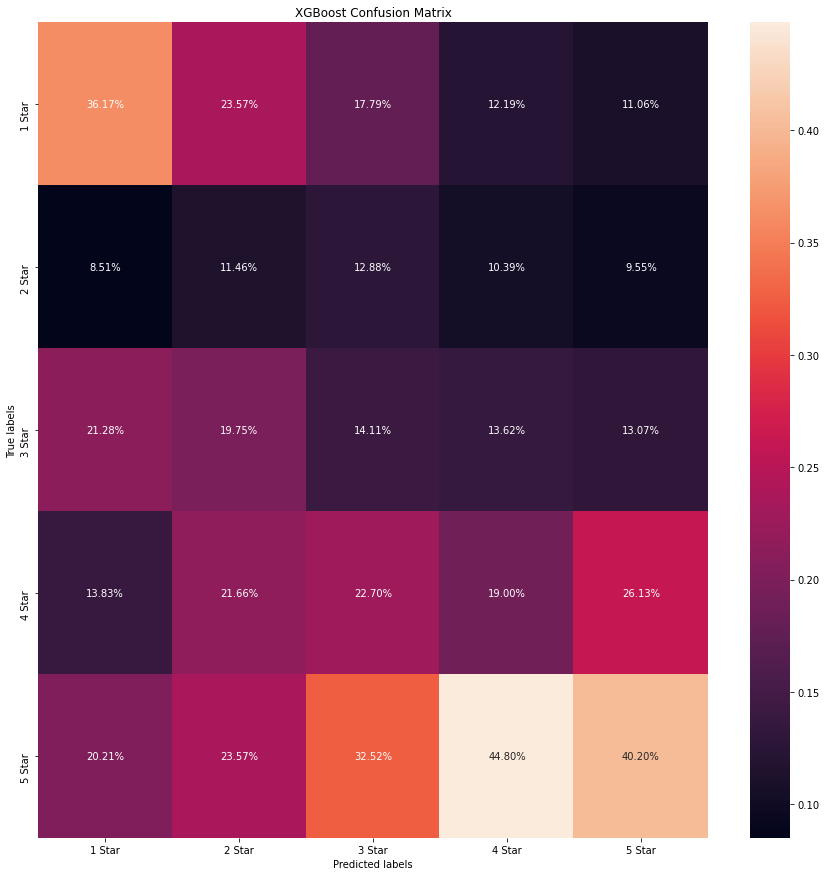

In [ ]:
labs =['1 Star','2 Star','3 Star','4 Star', '5 Star']
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm2, annot=True, fmt= '.2%', ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('XGBoost Confusion Matrix'); 
ax.xaxis.set_ticklabels(labs); ax.yaxis.set_ticklabels(labs);

In [ ]:
cm3= confusion_matrix(recon.bkt.ravel(), recon.yhat.ravel(),normalize= 'pred')

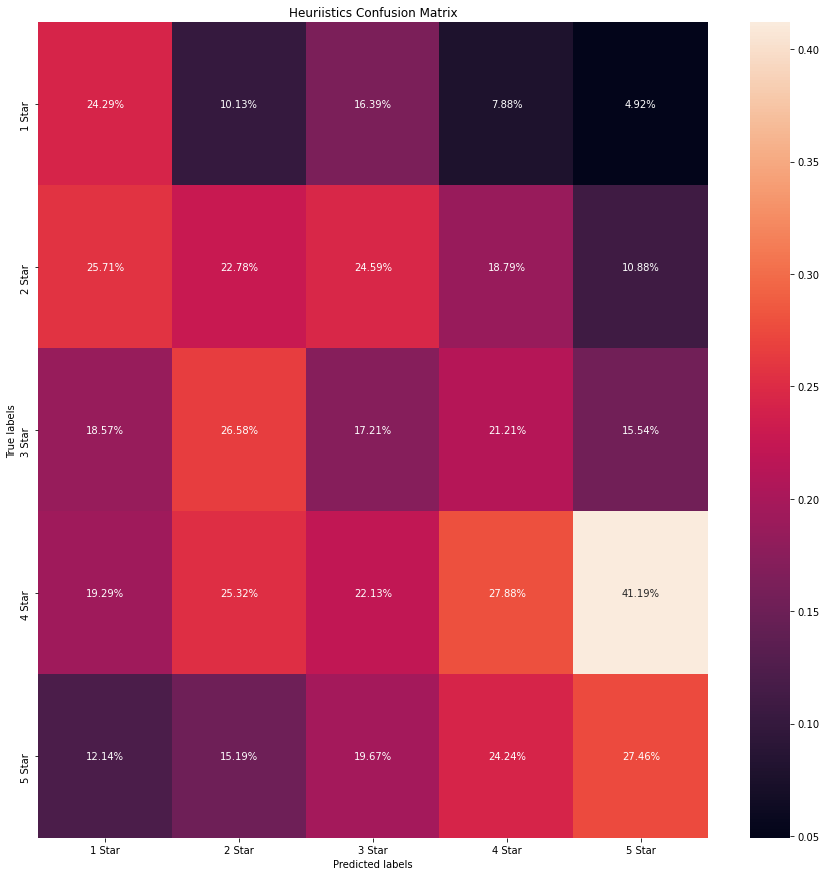

In [ ]:
labs =['1 Star','2 Star','3 Star','4 Star', '5 Star']
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(cm3, annot=True, fmt= '.2%', ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Heuriistics Confusion Matrix'); 
ax.xaxis.set_ticklabels(labs); ax.yaxis.set_ticklabels(labs);

In [ ]:
recon['xcorrect']= recon['y']== recon['yhat']
recon['rcorrect']= recon['y']== recon['bkt']
recon['imprv'] = recon['xcorrect'].astype('int')- recon['rcorrect'].astype('int')

In [ ]:
improved= recon.groupby(['y','bkt'])['imprv'].agg(['sum']).astype('float').unstack()
counts= recon.groupby(['y','bkt'])['imprv'].agg(['count']).astype('float').unstack()

In [ ]:
v= improved.values/ counts.values

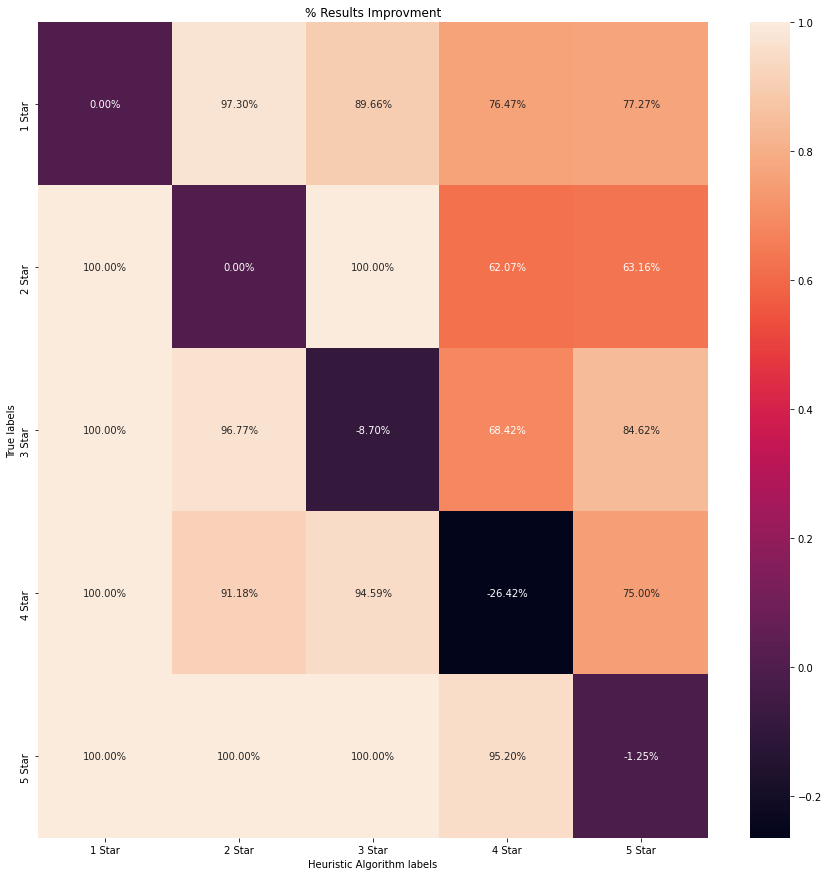

In [ ]:
labs =['1 Star','2 Star','3 Star','4 Star', '5 Star']
plt.figure(figsize=(15,15))
ax= plt.subplot()
sns.heatmap(v, annot=True, fmt= '.2%', ax = ax)
ax.set_xlabel('Heuristic Algorithm labels');ax.set_ylabel('True labels'); 
ax.set_title('% Results Improvment'); 
ax.xaxis.set_ticklabels(labs); ax.yaxis.set_ticklabels(labs);

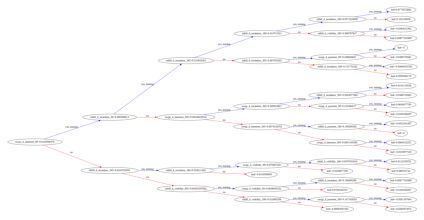

In [ ]:
ax = plt.subplot(1,1,1)
plot_tree(xgb1, num_trees=4, ax = ax, rankdir='LR')
plt.tight_layout()
plt.show()

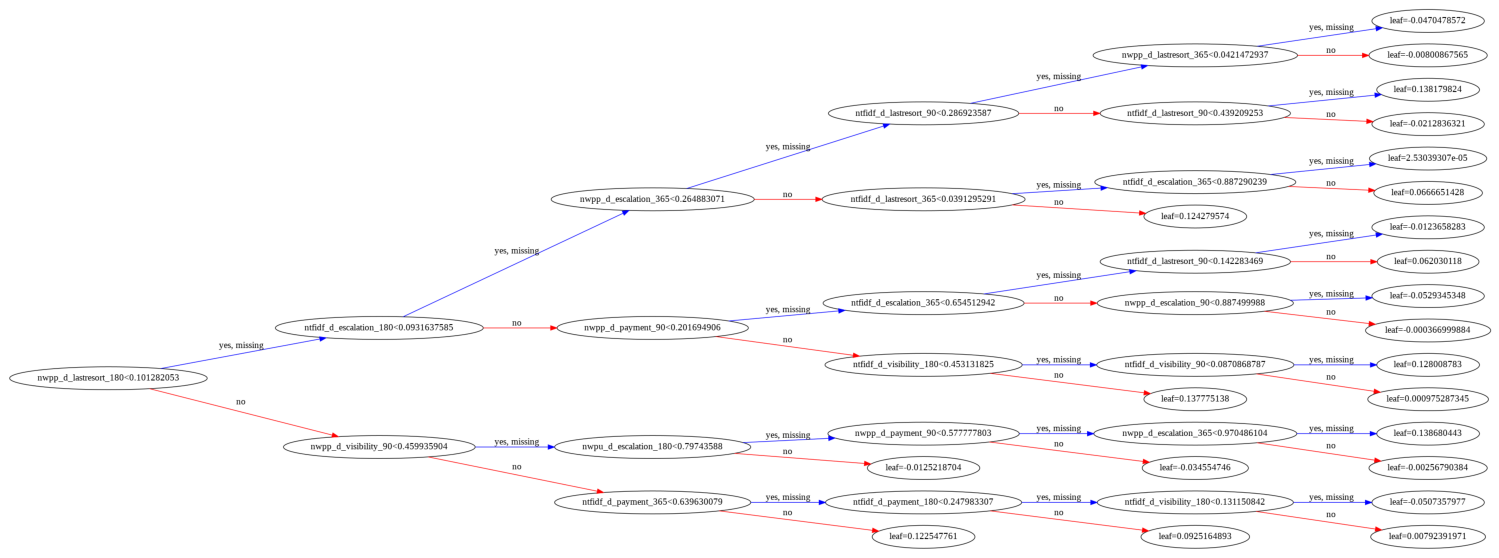

In [ ]:
xgb.plot_tree(xgb1,num_trees=5, rankdir='LR')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

# Appendix-A: Random Forest Model

In [ ]:
model = RandomForestClassifier(verbose = 1,random_state= RSEED,n_estimators=1000,min_samples_split=10, criterion= 'entropy')

In [ ]:
scores = cross_val_score(model, train.values, labels.values.ravel(), cv=5,scoring= 'neg_log_loss')
print(scores.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

-1.5234443602805565


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [ ]:
model.fit(train.values, labels.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [ ]:
model.feature_importances_

array([0.03866377, 0.02719103, 0.02606222, 0.01991764, 0.03249013,
       0.02480132, 0.0251097 , 0.02418126, 0.04161214, 0.03318513,
       0.03414231, 0.01955164, 0.03663357, 0.0259118 , 0.02388255,
       0.01818026, 0.03117445, 0.02325386, 0.02335611, 0.02376405,
       0.03931601, 0.03051839, 0.0315996 , 0.02122704, 0.03615283,
       0.0263827 , 0.02362957, 0.01788539, 0.03040405, 0.02376029,
       0.02503223, 0.02285837, 0.03803458, 0.02927256, 0.03074901,
       0.02011244])

In [ ]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

Feature ranking:
1. feature 8 (0.041612)
2. feature 20 (0.039316)
3. feature 0 (0.038664)
4. feature 32 (0.038035)
5. feature 12 (0.036634)
6. feature 24 (0.036153)
7. feature 10 (0.034142)
8. feature 9 (0.033185)
9. feature 4 (0.032490)
10. feature 22 (0.031600)
11. feature 16 (0.031174)
12. feature 34 (0.030749)
13. feature 21 (0.030518)
14. feature 28 (0.030404)
15. feature 33 (0.029273)
16. feature 1 (0.027191)
17. feature 25 (0.026383)
18. feature 2 (0.026062)
19. feature 13 (0.025912)
20. feature 6 (0.025110)
21. feature 30 (0.025032)
22. feature 5 (0.024801)
23. feature 7 (0.024181)
24. feature 14 (0.023883)
25. feature 19 (0.023764)
26. feature 29 (0.023760)
27. feature 26 (0.023630)
28. feature 18 (0.023356)
29. feature 17 (0.023254)
30. feature 31 (0.022858)
31. feature 23 (0.021227)
32. feature 35 (0.020112)
33. feature 3 (0.019918)
34. feature 11 (0.019552)
35. feature 15 (0.018180)
36. feature 27 (0.017885)


<Figure size 1800x504 with 0 Axes>

Text(0.5, 1.0, 'Feature importances')

<BarContainer object of 36 artists>

([<matplotlib.axis.XTick at 0x7f70ce836b70>,
 <a list of 36 Text xticklabel objects>)

(-1, 36)

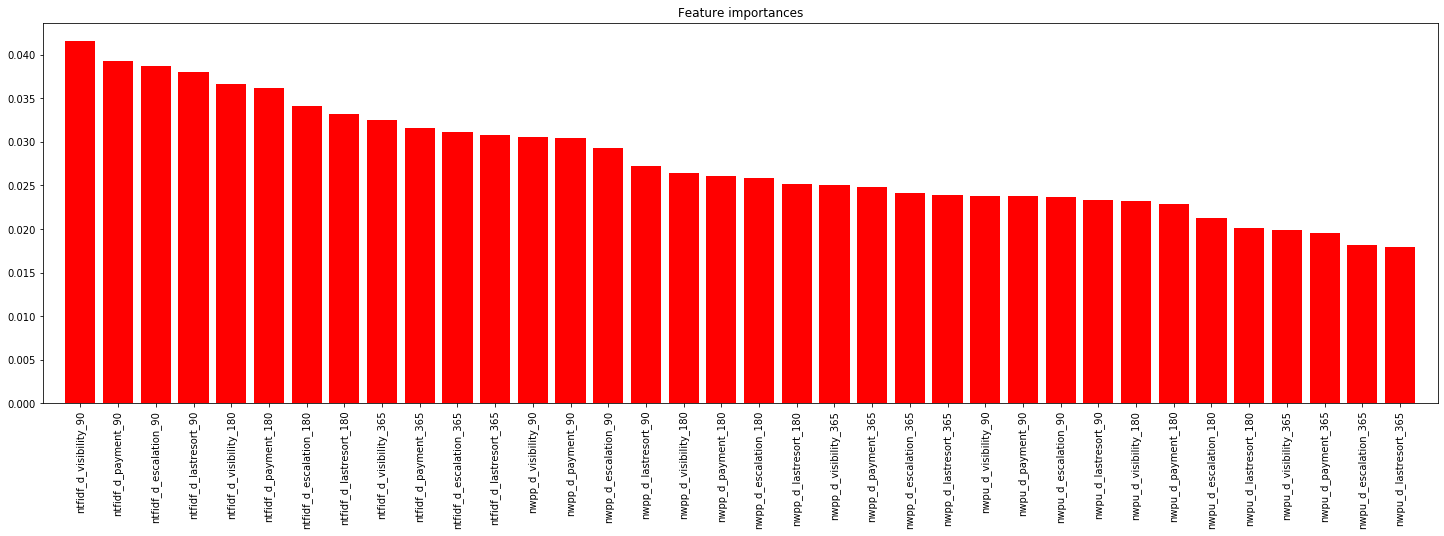

In [ ]:
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize= (25,7))
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), labels=train.columns, rotation='vertical')
plt.xlim([-1, train.shape[1]])

In [ ]:
train.columns[0]

'ntfidf_visibility_90'

In [ ]:
ypred= model.predict(train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [ ]:
print("\nModel Report")
print("Recall Micro : %.4g" % recall_score(labels.values.ravel(), ypred, average= 'micro'))
print("Recall Macro : %.4g" % recall_score(labels.values.ravel(), ypred, average= 'macro'))
print("Recall Weighted : %.4g" % recall_score(labels.values.ravel(), ypred, average= 'weighted'))
print("Precision Micro : %.4g" % precision_score(labels.values.ravel(), ypred, average= 'micro'))
print("Precision Macro : %.4g" % precision_score(labels.values.ravel(), ypred, average= 'macro'))
print("Precision Weighted : %.4g" % precision_score(labels.values.ravel(), ypred, average= 'weighted'))
print("Neg Log Loss (Train): %f" % log_loss(labels.values.ravel(), model.predict_proba(train)))


Model Report
Recall Micro : 0.787
Recall Macro : 0.7348
Recall Weighted : 0.787
Precision Micro : 0.787
Precision Macro : 0.8387
Precision Weighted : 0.8109


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Neg Log Loss (Train): 0.900765


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [ ]:
confusion_matrix(labels.values.ravel(), ypred, labels=['1 Star', '2 Star', '3 Star',
                                     '4 Star', '5 Star'], normalize='true')*100

array([[76.9047619 ,  2.61904762,  9.28571429,  2.14285714,  9.04761905],
       [10.52631579, 57.89473684, 17.00404858,  3.2388664 , 11.33603239],
       [ 7.60233918,  3.21637427, 76.60818713,  3.50877193,  9.06432749],
       [ 9.6196868 ,  3.57941834, 19.46308725, 54.8098434 , 12.52796421],
       [13.52941176,  7.41176471, 21.52941176,  7.29411765, 50.23529412]])

In [ ]:
log_loss(labels.values.ravel(), model.predict_proba(train), normalize= True, eps=1e-15)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


1.120059454217681

In [ ]:
def logloss(true_label, predicted, eps=1e-15):
  p = np.clip(predicted, eps, 1 - eps)
  print(p)
  if true_label == 1:
    return -np.log(p)
  else:
    return -np.log(1 - p)

In [ ]:
logloss(0,0)

1e-15


9.992007221626415e-16

In [ ]:
def logloss_prob(yt, yp):
  return(-(yt*np.log(yp) + (1 - yt)*np.log(1 - yp)))

In [ ]:
for i in range(0,100):
  p = i*.01
  print(p,logloss_prob(1,p))

0.0 inf
0.01 4.605170185988091
0.02 3.912023005428146
0.03 3.506557897319982
0.04 3.2188758248682006
0.05 2.995732273553991
0.06 2.8134107167600364
0.07 2.659260036932778
0.08 2.5257286443082556
0.09 2.4079456086518722
0.1 2.3025850929940455
0.11 2.2072749131897207
0.12 2.120263536200091
0.13 2.0402208285265546
0.14 1.9661128563728327
0.15 1.8971199848858813
0.16 1.8325814637483102
0.17 1.7719568419318752
0.18 1.7147984280919266
0.19 1.6607312068216509
0.2 1.6094379124341003
0.21 1.5606477482646683
0.22 1.5141277326297755
0.23 1.4696759700589417
0.24 1.4271163556401458
0.25 1.3862943611198906
0.26 1.3470736479666092
0.27 1.3093333199837622
0.28 1.2729656758128873
0.29 1.2378743560016174
0.3 1.2039728043259361
0.31 1.171182981502945
0.32 1.1394342831883648
0.33 1.1086626245216111
0.34 1.0788096613719298
0.35000000000000003 1.0498221244986776
0.36 1.0216512475319814
0.37 0.9942522733438669
0.38 0.9675840262617056
0.39 0.941608539858445
0.4 0.916290731874155
0.41000000000000003 0.89159811

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
